## Cancer clusters

### The question

<div>
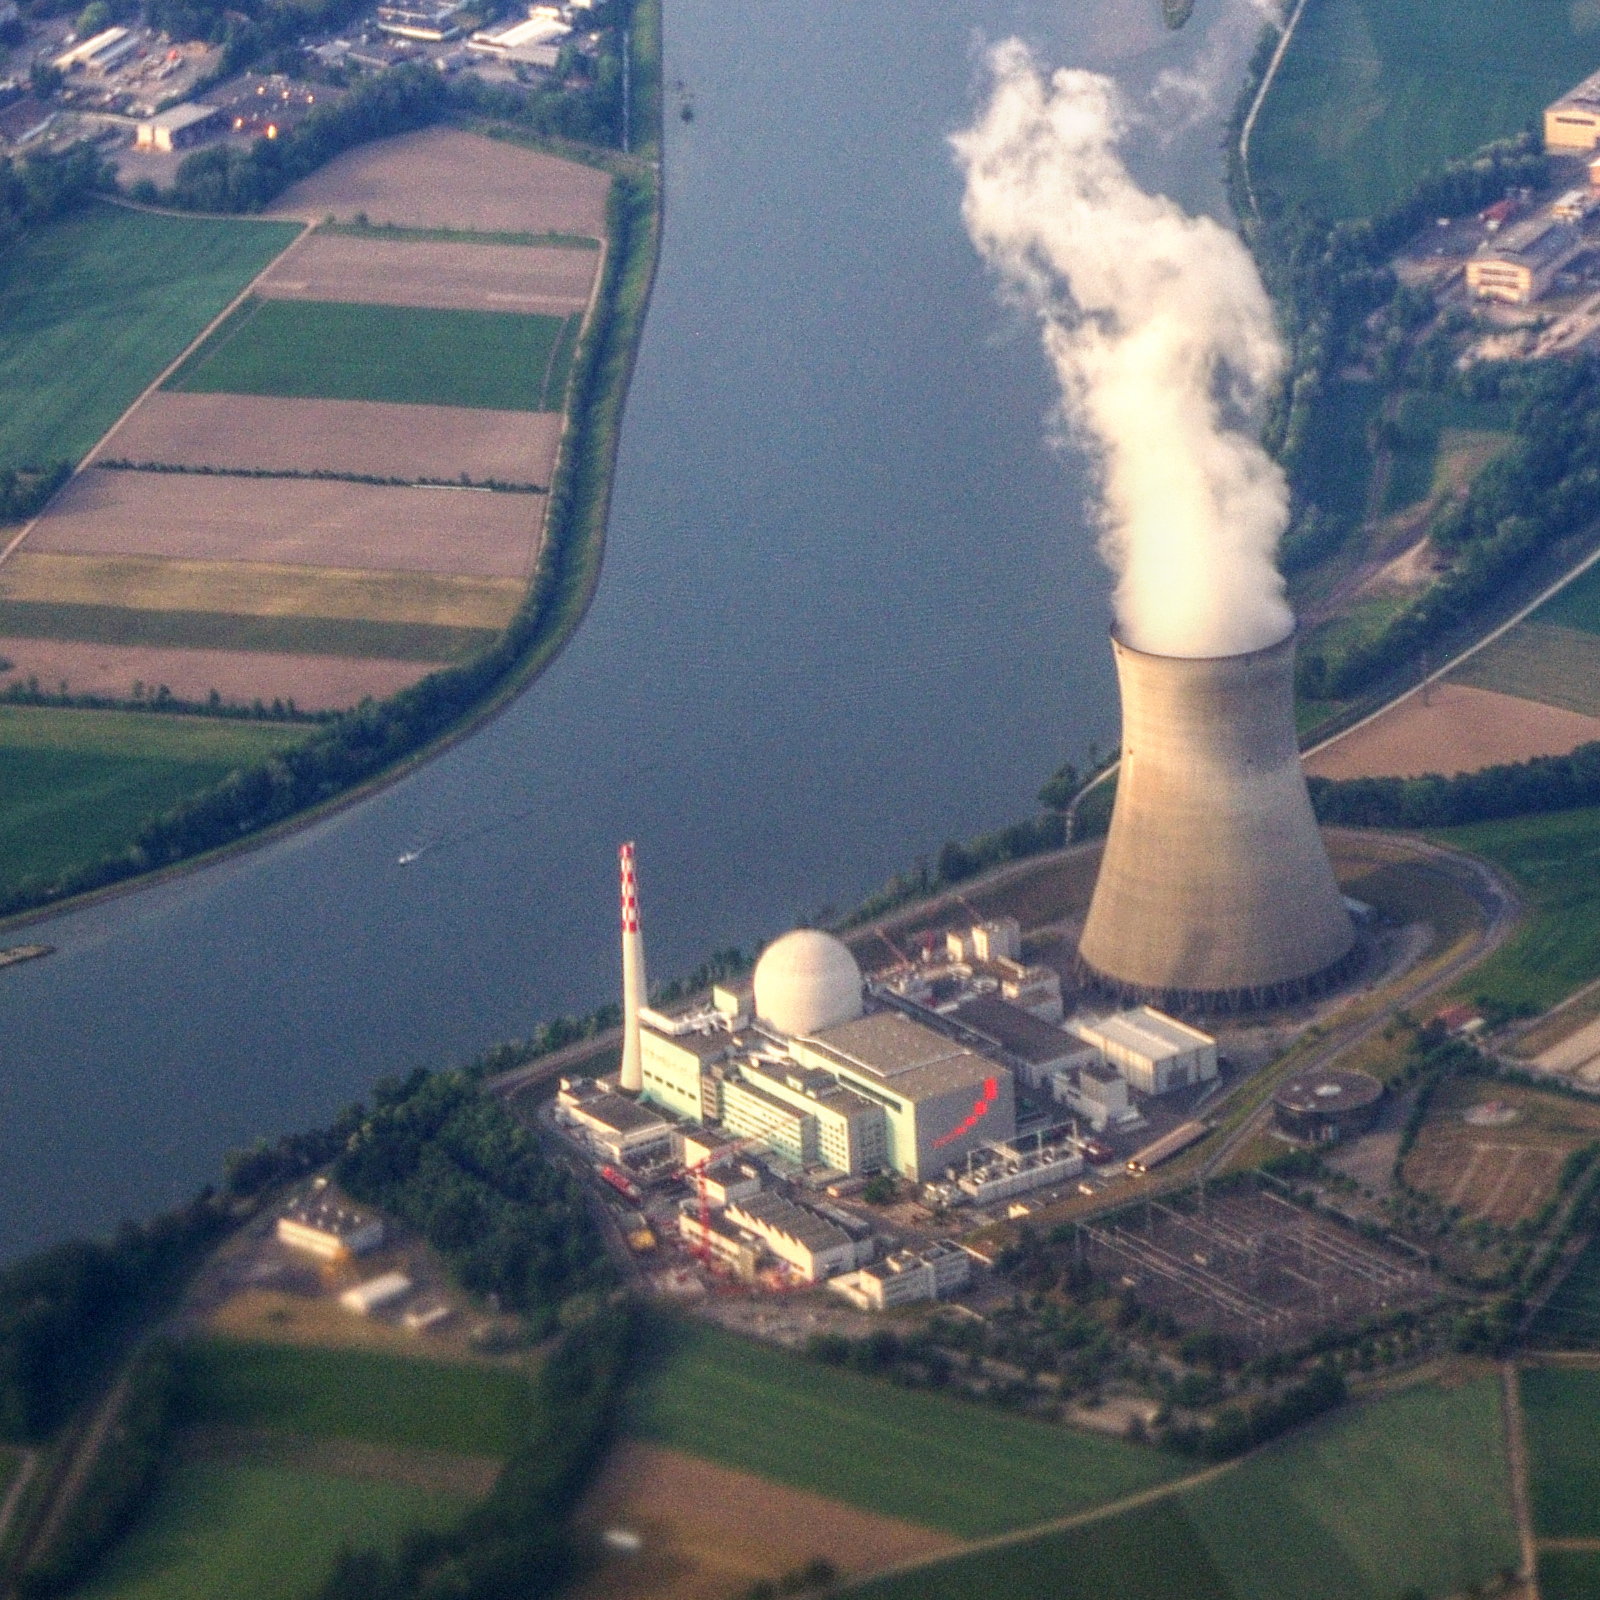
</div>

This dataset has counts of prostate cancer (cancer clusters) in clinics and distance of each clinic from a nuclear processing plant. The question is whether the data provide any evidence that the number of cancer cases increases with proximity to the nuclear plant. And, if so, what is the numerical relationship between distance and size of the clusters.

These are our null and alternative hypotheses.

- $H_0$: cancer cases are not related to distance to nuclear plant
- $H_A$: cancer cases are related to distance to nuclear plant

And, if we reject the null hypothesis, what is the expected number of cases for clinics a given distance from the nuclear plant?

### Imports

In [2]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Poisson

### Load and print the data

First we read in the dataset and print it to see how it looks and what the variable names, types and values are.

In [3]:
clusters = pd.read_csv('../Datasets/cancer_clusters.csv')
clusters

,distance,cancers
0,0,5
1,0,3
2,0,4
3,5,3
4,5,2
...,...,...
112,96,0
113,98,0
114,98,0
115,99,0


Variable names are "distance" and "cancers". The variable "distance" is continuous and is the distance in kilometers to the nuclear reprocessing plant from the clinic where the diagnosis was made. The variable "cancers" is the number of prostate cancers at each clinic. Some clinics recorded no cancers. 

"distance" is the explanatory variable and "cancers" in the response variable.

As both variables are numerical we should plot them as a scatter plot. Seaborn's lmplot will automatically fit the model `cancers ~ distance`.

### Plot the data

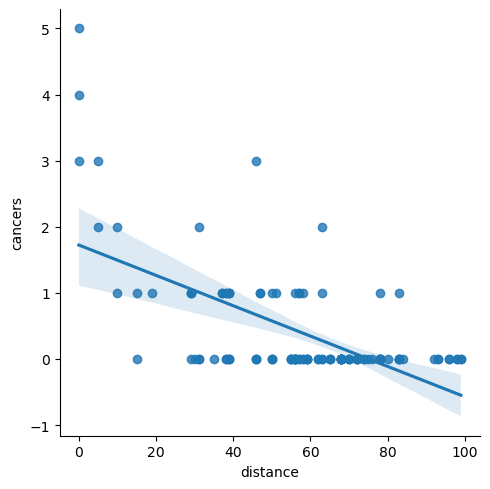

In [4]:
sns.lmplot(x='distance', y='cancers', data=clusters);

There is a downward trend: the further a clinic is away from the nuclear plant the fewer cancer cases it records.

Seaborn has fitted the linear regression model `cancers ~ distance` to the data and plotted the regression line with 95% CI. Apart from it not fitting the data well, it also predicts negative number of cases from 80 to 100 km. This is of course impossible which tells us that the regression model Seaborn has fitted is wrong.

When we have count data like "number of cancer cases" we should not use `ols` to fit our model. Instead we should use a method called `glm` which stands for "generalised linear model". We also have to include `family=Poisson()` in the call to `glm` to tell it that the data are counts rather than a continuous. This is called **log-linear** regression.

The code below shows how it works. 

### Code and fit the model

In [5]:
formula = 'cancers ~ distance'
fit = glm(formula, clusters, family=Poisson()).fit()
fit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.1577,0.219,5.282,0.000,0.728,1.587
distance,-0.0471,0.006,-7.963,0.000,-0.059,-0.035


Notice that `glm` uses the *z*-statistic rather than the *t*-statistic. We don't need to worry ourselves why, it's not really important. But we do need to report the value of *z* rather than *t*. 

### Interpret the summary of the model fit

Both `Intercept` and `distance` are significant (*p* < 0.001 for both). However, unlike `ols` where the coefficient estimates are directly interpretable as the *y*-intercept and slope of a straight line, when we use `glm` with `family=Poisson()` these coefficients require a little more manipulation. The regression line fitted to the data has the form

$$
\mathrm{rate\ of\ cancer\ cases} = \exp(\mathrm{intercept} + \mathrm{slope} \times \mathrm{distance})
$$

Substituting in the values from the summary table we have

$$
\mathrm{rate\ of\ cancer\ cases} = \exp(1.16 -0.047 \times \mathrm{distance})
$$

In order to fix seaborn's plot of the model fit we fortunately do not need to do this calculation ourselves; `glm` has already done it for us (and in addition calculated the 95% CI of the regression line), we just need to access them using the following code

In [6]:
res = fit.get_prediction().summary_frame()
res

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,3.182460,0.697534,2.071075,4.890238
1,3.182460,0.697534,2.071075,4.890238
2,3.182460,0.697534,2.071075,4.890238
3,2.514868,0.496730,1.707608,3.703755
4,2.514868,0.496730,1.707608,3.703755
...,...,...,...,...
112,0.034642,0.014703,0.015077,0.079596
113,0.031529,0.013734,0.013425,0.074045
114,0.031529,0.013734,0.013425,0.074045
115,0.030079,0.013271,0.012668,0.071418


This is a pandas dataframe with the regression line in column `mean` and the 95% CI in columns `mean_ci_lower` and `mean_ci_upper`. 

To use this dataframe to construct a plot of the regression line we add the `distance` column from `clusters` to this dataframe.

In [7]:
res['distance'] = clusters['distance']
res

,mean,mean_se,mean_ci_lower,mean_ci_upper,distance
0,3.182460,0.697534,2.071075,4.890238,0
1,3.182460,0.697534,2.071075,4.890238,0
2,3.182460,0.697534,2.071075,4.890238,0
3,2.514868,0.496730,1.707608,3.703755,5
4,2.514868,0.496730,1.707608,3.703755,5
...,...,...,...,...,...
112,0.034642,0.014703,0.015077,0.079596,96
113,0.031529,0.013734,0.013425,0.074045,98
114,0.031529,0.013734,0.013425,0.074045,98
115,0.030079,0.013271,0.012668,0.071418,99


Then plot the data as a scatterplot and add the regression line with 95% CIs.

In [8]:
# plot the data as a scatterplot, save the figure as ax for plotting the regression line
ax = sns.scatterplot(x='distance', y='cancers', data=clusters)

# plot the regression line
ax.plot('distance', 'mean', data=res)

# plot a 95% CI band with fill_between between the lower and upper 95% limits
ax.fill_between('distance', 'mean_ci_lower', 'mean_ci_upper', data=res, linewidth=0, color='C0', alpha=0.5);

That looks better. The rate of cancer cases tends toward zero the further away a clinic is from the nuclear plant.

### Report the outcome of the test

There is a statistically significant rise in the rate of cancer cases the closer a clinic is to the nuclear plant (*z* = 7.963, *p* < 0.001).